In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import skimage.measure
import os
from sklearn.model_selection import train_test_split
from cv2 import resize

from keras.initializers import RandomNormal
from keras.callbacks import ModelCheckpoint
from keras.models import *
from keras.layers import *
from keras.optimizers import SGD, Adam
from keras.models import model_from_json
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

C:\Users\Max\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Max\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\Max\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [21]:
X_raw = np.load("data/images.npy")
y = np.load("data/labels.npy")
y = [val[0] for val in y]
X = []

for i in range(len(X_raw)):
    X.append(resize(X_raw[i],(224,224)))
    X[i] = preprocess_input(X[i]) #480x640

# del X_raw
    
# setting features and target value
X = np.asarray(X)
y = np.asarray(y)

# train test split
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
_, X_raw, _, _ = train_test_split(X_raw, X_raw, test_size=0.1, random_state=123) #for plotting

# validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=123)

del X, y

In [10]:
VGG_16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [11]:
VGG_16 = Model(VGG_16.input, VGG_16.layers[-6].output)

for layer in VGG_16.layers[:-2]:
    layer.trainable = False

Map_estimator_net = Sequential([
            Conv2D(512, (3, 3), dilation_rate = 2, padding = 'same', kernel_initializer = RandomNormal(stddev=0.01)),
            LeakyReLU(alpha=0.01),
            Conv2D(512, (3, 3), dilation_rate = 2, padding = 'same', kernel_initializer = RandomNormal(stddev=0.01)),
            LeakyReLU(alpha=0.01),
            Conv2D(512, (3, 3), dilation_rate = 2, padding = 'same', kernel_initializer = RandomNormal(stddev=0.01)),
            LeakyReLU(alpha=0.01),
            Conv2D(256, (3, 3), dilation_rate = 2, padding = 'same', kernel_initializer = RandomNormal(stddev=0.01)),
            LeakyReLU(alpha=0.01),
            Conv2D(128, (3, 3), dilation_rate = 2, padding = 'same', kernel_initializer = RandomNormal(stddev=0.01)),
            LeakyReLU(alpha=0.01),
            Conv2D(64, (3, 3), dilation_rate = 2, padding = 'same', kernel_initializer = RandomNormal(stddev=0.01)),
            LeakyReLU(alpha=0.01),        
            Conv2D(1, (1, 1), dilation_rate = 1, padding = 'same', kernel_initializer = RandomNormal(stddev=0.01)),
            LeakyReLU(alpha=0.01)
            ])(VGG_16.output)


CSRnet = Model(inputs=VGG_16.input, outputs=Map_estimator_net)
CSRnet.compile(optimizer=Adam(1e-2), loss = "mae", metrics=["mse"])
# CSRnet.load_weights(".trained_models/csrnet/csrnet_model_unfrozen.h5")

for layer in CSRnet.layers[:]:
    layer.trainable = False

In [12]:
Regressor_one_layer = Sequential([
    Flatten(),
    Dense(1, kernel_initializer = RandomNormal(mean = 1.,stddev=0.001)),
])(CSRnet.output)

Regressor = Model(inputs=CSRnet.input, outputs=Regressor_one_layer)

Regressor.compile(Adam(1e-2), loss = "mae", metrics=["mse"])
Regressor.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [81]:
checkpoint_filepath = './checkpoint_regressor'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_mse',
    mode='min',
    save_best_only=True)

history = Regressor.fit(X_train, y_train,
                             batch_size = 1, epochs = 20,
                             validation_data=(X_val,y_val), 
                             callbacks=[model_checkpoint_callback]
                         )

Regressor.load_weights(checkpoint_filepath)

Epoch 1/20
1620/1620 [==============================] - 190s 117ms/step - loss: 2.2192 - mse: 8.6096 - val_loss: 2.4868 - val_mse: 9.8894
Epoch 2/20
1620/1620 [==============================] - 190s 117ms/step - loss: 2.2064 - mse: 8.5653 - val_loss: 2.4397 - val_mse: 10.1316
Epoch 3/20
1620/1620 [==============================] - 190s 117ms/step - loss: 2.2010 - mse: 8.5611 - val_loss: 2.4775 - val_mse: 9.9364
Epoch 4/20
1620/1620 [==============================] - 190s 117ms/step - loss: 2.2003 - mse: 8.5294 - val_loss: 2.4508 - val_mse: 10.3685
Epoch 5/20
1620/1620 [==============================] - 190s 117ms/step - loss: 2.1955 - mse: 8.4913 - val_loss: 2.4308 - val_mse: 9.8657
Epoch 6/20
1620/1620 [==============================] - 190s 117ms/step - loss: 2.1835 - mse: 8.4256 - val_loss: 2.4237 - val_mse: 9.9266
Epoch 7/20
1620/1620 [==============================] - 190s 117ms/step - loss: 2.1683 - mse: 8.3735 - val_loss: 2.4229 - val_mse: 10.0779
Epoch 8/20
1620/1620 [=========

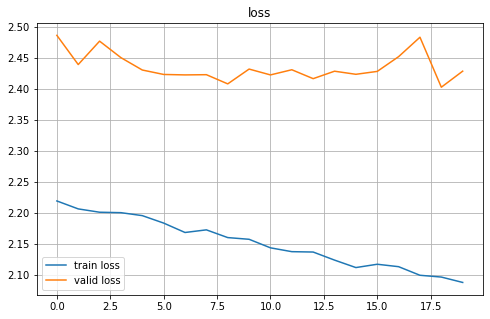

In [82]:
def plot_learning_curves(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.epoch,history.history['loss'], label='train loss')
    plt.plot(history.epoch,history.history['val_loss'], label='valid loss')
    plt.legend()
    plt.title('loss')
    plt.grid(True)
    plt.show()
plot_learning_curves(history)

In [83]:
# serialize weights to HDF5
Regressor.save_weights("regressor_one_layer.h5")

In [84]:
score = Regressor.evaluate(X_test, y_test, verbose=0)
print(score[0])

2.483612060546875


In [13]:
Regressor.load_weights("./trained_models/csrnet/regressor_one_layer.h5")

In [55]:
worst_prediction = 0
worst_prediction_error = 0
worst_idx = 0

best_prediction = np.inf
best_prediction_error = np.inf
best_idx = np.inf

preds = []

N = len(y_test)
for i, (x, y) in enumerate(zip(X_test, y_test)):
    if i % 10 == 0: 
        print("                                                        ", end = '\r')
        print(f"{round(i/N,2) * 100}% of predictions done", end = '\r')

    pred = (Regressor.predict(np.reshape(np.asarray(x),(1,x.shape[0],x.shape[1],x.shape[2]))))
    preds.append(pred[0,0])
    error = np.abs(pred - y)
    if error > worst_prediction_error:
        worst_prediction = pred
        worst_prediction_error = error
        worst_idx = i
        
    if error < best_prediction_error:
        best_prediction = pred
        best_prediction_error = error
        best_idx = i

print()

95.0% of predictions done                               


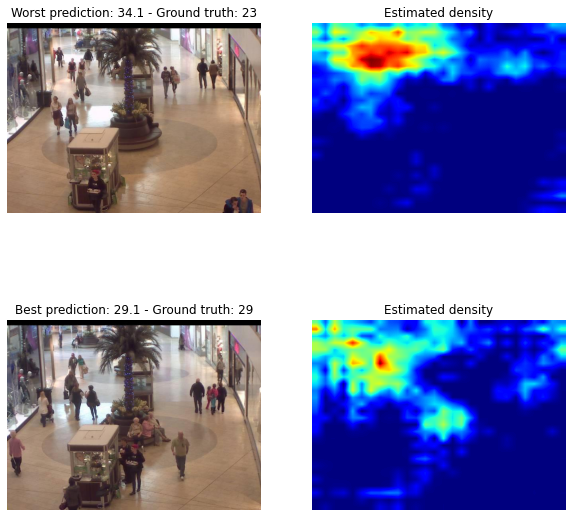

In [54]:
plt.figure(figsize=(10, 10))
    
plt.subplot(2, 2, 1)
plt.title(f"Worst prediction: {round(worst_prediction[0,0],1):.1f} - Ground truth: {y_test[worst_idx]}")
plt.axis('off')
_ = plt.imshow(X_raw[worst_idx])

plt.subplot(2, 2, 2)
plt.title(f"Estimated density")
plt.axis('off')
estimated_dens = CSRnet.predict(np.reshape(X_test[worst_idx],(1,X_test[worst_idx].shape[0],X_test[worst_idx].shape[1],X_test[worst_idx].shape[2])))
estimated_dens = estimated_dens.reshape((estimated_dens.shape[1], estimated_dens.shape[2], 1))
_ = plt.imshow(resize(estimated_dens, (X_raw[worst_idx].shape[1],X_raw[worst_idx].shape[0])) , cmap = "jet")

plt.subplot(2, 2, 3)
plt.title(f"Best prediction: {round(best_prediction[0,0],1):.1f} - Ground truth: {y_test[best_idx]}")
plt.axis('off')
_ = plt.imshow(X_raw[best_idx])

plt.subplot(2, 2, 4)
plt.title(f"Estimated density")
plt.axis('off')
estimated_dens = CSRnet.predict(np.reshape(X_test[best_idx],(1,X_test[best_idx].shape[0],X_test[best_idx].shape[1],X_test[best_idx].shape[2])))
estimated_dens = estimated_dens.reshape((estimated_dens.shape[1], estimated_dens.shape[2], 1))
_ = plt.imshow(resize(estimated_dens, (X_raw[best_idx].shape[1],X_raw[best_idx].shape[0])) , cmap = "jet")


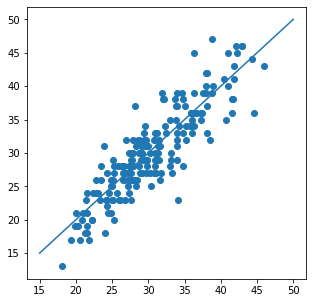

In [64]:
plt.figure(figsize=(5, 5))
plt.scatter(preds, y_test)
_ = plt.plot([15,50],[15,50])